In [2]:
import pickle
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
import gurobipy as gp
from gurobipy import GRB

In [3]:
import warnings

warnings.filterwarnings("ignore", message="Could not infer format, so each element")
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Data Preprocessing

In [10]:
# --------------------------------------------------
# Helper function
# --------------------------------------------------
def expand_pkg_to_core(pkg_df, n_cores):
    """
    Expand package-level power (rows × sockets) to core-level (rows × n_cores),
    by dividing each socket's power equally among its cores.
    Assumes equal number of cores per socket.
    """
    sockets = pkg_df.shape[1]
    cores_per_socket = n_cores // sockets
    core_power = pd.DataFrame(index=pkg_df.index,
                              columns=range(n_cores),
                              dtype=float)
    for sock in range(sockets):
        power_per_core = pkg_df.iloc[:, sock] / cores_per_socket
        start = sock * cores_per_socket
        end = start + cores_per_socket
        core_power.iloc[:, start:end] = power_per_core.values[:, None]
        
    return core_power

# --------------------------------------------------
# Load data
# --------------------------------------------------
file_path = "../data/MAR2_al/MAR2_hpl/65k_64_56/round0/preprocessing/round0.pkl"
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# --------------------------------------------------
# Extract raw metrics
# --------------------------------------------------
freq_df   = data['C0_norm_tsc_freq_core']
temp_df   = data['temp_core']
aperf_df  = data['aperf_core']
mperf_df  = data['mperf_core']
power_pkg = data['power_from_erg_pkg_cpu']

# Dimensions
N = freq_df.shape[1]
M = 5  # number of discrete frequency states

# ILP parameters
n_jobs = 10
T_max  = 100.0

In [9]:
# --------------------------------------------------
# Expand package-level power to per-core
# --------------------------------------------------
power_core_raw = expand_pkg_to_core(power_pkg, N)

# --------------------------------------------------
# Allocate power proportionally to utilization
# --------------------------------------------------
util_ratio = aperf_df / mperf_df
util_norm  = util_ratio.div(util_ratio.sum(axis=1), axis=0)
power_core = util_norm.mul(power_core_raw)

# --------------------------------------------------
# Cluster frequency to derive f_ij and P_ij
# --------------------------------------------------
freq_vals = freq_df.values.reshape(-1, 1)
kmeans    = KMeans(n_clusters=M, random_state=0).fit(freq_vals)
labels    = kmeans.labels_.reshape(freq_df.shape)

f_ij = np.zeros((N, M))
P_ij = np.zeros((N, M))
for i in range(N):
    for j in range(M):
        mask = labels[:, i] == j
        if mask.any():
            f_ij[i, j] = freq_df.values[mask, i].mean()
            P_ij[i, j] = power_core.values[mask, i].mean()

# --------------------------------------------------
# Ambient temperature and idle power
# --------------------------------------------------
c0_df = data['C0_norm_tsc_core']
idle_mask = c0_df <= 0.05
p_bar = power_core[idle_mask].mean().mean()

In [11]:
# find the cluster whose centroid is closest to your C0-threshold (say f≈0.05)
idle_centroids = kmeans.cluster_centers_.flatten()
idle_label = np.argmin(np.abs(idle_centroids - 0.05))
P_idle_all_cores = P_ij[:, idle_label]
print(f"mean P_idle:{np.mean(P_idle_all_cores.mean()): .4f}")
print(f"median P_idle:{np.median(P_idle_all_cores): .4f}")
print(f"p_bar:{p_bar: .4f}")

mean P_idle: 0.0236
median P_idle: 0.0244
p_bar: 0.0233


## Modelling 

In [12]:
# --------------------------------------------------
# Fit neural-net surrogate for GS
# --------------------------------------------------
# delta_T: temperature rise above ambient for each core
T_a = temp_df.min().values
delta_T = (temp_df - T_a).values  # shape (timesteps, N)
# P_mat: per-core power time series as input features
P_mat = power_core.values        # shape (timesteps, N)

GS = np.zeros((N, N))
for ell in range(N):
    mlp = MLPRegressor(hidden_layer_sizes=(50,), activation='relu', max_iter=1000, tol=1e-4, random_state=0, verbose=False)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        mlp.fit(P_mat, delta_T[:, ell])
    # Extract weights
    W1 = mlp.coefs_[0]        # shape (N, hidden_units)
    W2 = mlp.coefs_[1].flatten()  # shape (hidden_units,)
    # Compute effective linear mapping: GS_row ≈ W1 @ W2
    GS_row = W1.dot(W2)
    GS[ell, :] = GS_row

In [13]:
print(f"GS diag median (°C/W): {np.median(np.diag(GS)):.4f}")

GS diag median (°C/W): 2.7780


Raw 99th percentile: 10.93 °C/W


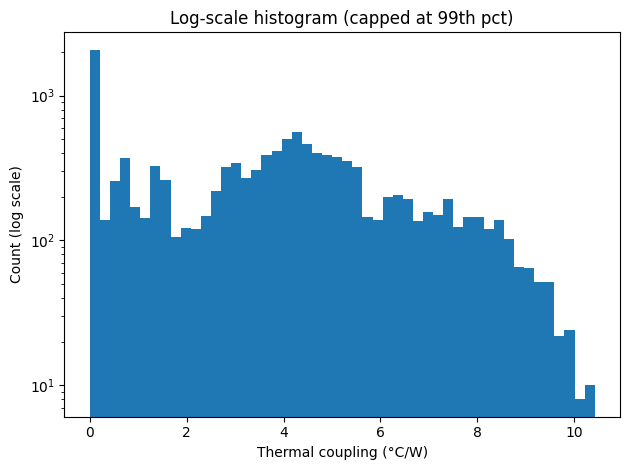


Raw percentiles:
  50th: 2.15 °C/W
  75th: 7.13 °C/W
  90th: 8.91 °C/W
  99th: 10.93 °C/W

Capped percentiles:
  50th: 3.84 °C/W
  75th: 5.29 °C/W
  90th: 7.32 °C/W
  99th: 9.35 °C/W


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Compute the raw off-diagonal values and their 99th percentile
mask_off    = ~np.eye(GS.shape[0], dtype=bool)
raw_vals    = np.maximum(GS, 0.0)[mask_off]  # clip negatives to zero before percentile
PHYS_MAX    = np.percentile(raw_vals, 99)    # ~10.9 °C/W

print(f"Raw 99th percentile: {PHYS_MAX:.2f} °C/W")

# 2) Clip the off-diagonals at PHYS_MAX, leave diagonals untouched
GS_cap      = np.maximum(GS, 0.0).copy()     # step‐1: zero out negatives
GS_cap[mask_off] = np.minimum(GS_cap[mask_off], PHYS_MAX)

# 3) Symmetrize and re‐clip in case asymmetry introduced small overshoots
GS_sym      = 0.5 * (GS_cap + GS_cap.T)
GS_sym[mask_off] = np.minimum(GS_sym[mask_off], PHYS_MAX)

# 4) Plot log‐scale histogram of the capped off-diagonals
off_capped  = GS_sym[mask_off]
plt.figure()
plt.hist(off_capped, bins=50, log=True)
plt.xlabel('Thermal coupling (°C/W)')
plt.ylabel('Count (log scale)')
plt.title('Log‐scale histogram (capped at 99th pct)')
plt.tight_layout()
plt.show()

# 5) Print percentiles before and after clipping
for name, vals in [("Raw", raw_vals), ("Capped", off_capped)]:
    pctls = np.percentile(vals, [50,75,90,99])
    print(f"\n{name} percentiles:")
    print(f"  50th: {pctls[0]:.2f} °C/W")
    print(f"  75th: {pctls[1]:.2f} °C/W")
    print(f"  90th: {pctls[2]:.2f} °C/W")
    print(f"  99th: {pctls[3]:.2f} °C/W")

# NN-static

In [15]:
# --------------------------------------------------
# Build and solve ILP with NN-based GS
# --------------------------------------------------
model = gp.Model("HPCEnergyScheduler_NN")
x = model.addVars(N, M, vtype=GRB.BINARY, name="x")
y = model.addVars(N,     vtype=GRB.BINARY, name="y")
model.setObjective(
    gp.quicksum(f_ij[i, j] * x[i, j] for i in range(N) for j in range(M)),
    GRB.MAXIMIZE
)
model.addConstr(
    gp.quicksum(x[i, j] for i in range(N) for j in range(M)) == n_jobs,
    name="total_jobs"
)
model.addConstr(
    gp.quicksum(y[i] for i in range(N)) == N - n_jobs,
    name="idle_count"
)
for i in range(N):
    model.addConstr(gp.quicksum(x[i, j] for j in range(M)) + y[i] == 1, name=f"assign_core_{i}")
    
for ell in range(N):
    expr = T_a[ell] + gp.quicksum(
        GS_sym[ell, i] * (p_bar * y[i] +
            gp.quicksum(P_ij[i, j] * x[i, j] for j in range(M))) for i in range(N))
    model.addConstr(expr <= T_max, name=f"thermal_core_{ell}")

model.optimize()

# --------------------------------------------------
# Extract and report results
# --------------------------------------------------
if model.status == GRB.OPTIMAL:
    x_sol = model.getAttr('x', x)
    y_sol = model.getAttr('x', y)
    core_power = {
        i: (p_bar if y_sol[i] > 0.5 else
            next(P_ij[i, j] for j in range(M) if x_sol[i, j] > 0.5))
        for i in range(N)
    }
    temps = [T_a[ell] + sum(GS[ell, i] * core_power[i] for i in range(N))
             for ell in range(N)]
    print("\nCore Assignments & NN-surrogate Temperatures:")
    for i in range(N):
        state = ('idle' if y_sol[i] > 0.5 else
                 f"state_{[j for j in range(M) if x_sol[i,j]>0.5][0]}")
        print(f"Core {i:3d}: {state:8s} | Temp: {temps[i]:6.2f} °C")

    print(f"Objective value: {model.ObjVal:.4f}\n")
    print(f"\nMax projected temp: {max(temps):.2f} °C (limit {T_max} °C)")
else:
    print(f"Model ended with status {model.status}")

Set parameter Username
Set parameter LicenseID to value 2615629
Academic license - for non-commercial use only - expires 2026-01-27
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Optimize a model with 226 rows, 672 columns and 59188 nonzeros
Model fingerprint: 0xca370963
Variable types: 0 continuous, 672 integer (672 binary)
Coefficient statistics:
  Matrix range     [1e-05, 1e+00]
  Objective range  [4e+01, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 8058.7744010
Presolve removed 225 rows and 560 columns
Presolve time: 0.01s
Presolved: 1 rows, 112 columns, 112 nonzeros
Found heuristic solution: objective 25713.341588
Variable types: 0 continuous, 112 integer (112 binary)

Root relaxation: objective 2.619480e+04, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Cur

## Embedded NN

In [16]:
# train ReLU net surrogate
aX = power_core.values  # (t,n)
ay = (temp_df - T_a).values  # (t,n)
mlp = MLPRegressor(hidden_layer_sizes=(50,), activation='relu',  alpha=0.0001, 
                   max_iter=10000, tol=1e-4, random_state=0)
mlp.fit(aX, ay)
W1, b1 = mlp.coefs_[0], mlp.intercepts_[0]  # (n,h),(h,)
W2, b2 = mlp.coefs_[1], mlp.intercepts_[1]  # (h,n),(n,)
h_size = W1.shape[1]

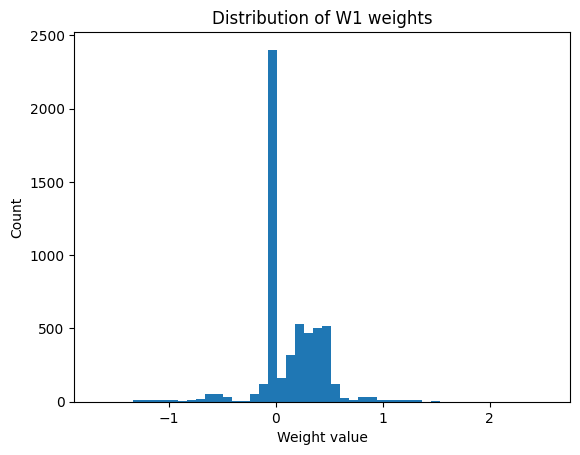

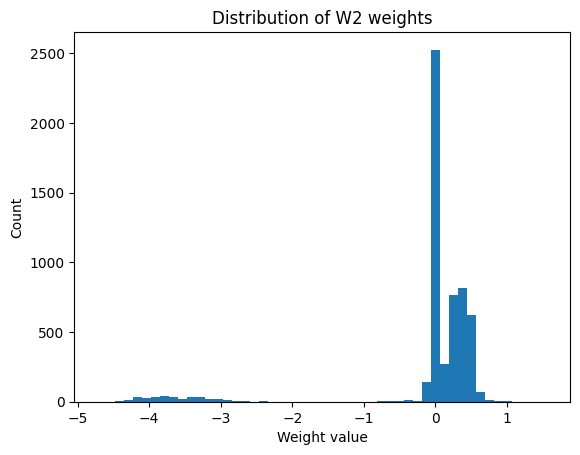

W1 zero‐like fraction: 0.4


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten and plot histograms of each layer’s weights
for W, name in [(W1, 'W1'), (W2, 'W2')]:
    plt.figure()
    plt.hist(W.flatten(), bins=50)
    plt.title(f'Distribution of {name} weights')
    plt.xlabel('Weight value')
    plt.ylabel('Count')
    plt.show()

# Check that most of W1 is near zero
print("W1 zero‐like fraction:", np.mean(np.isclose(W1, 0, atol=1e-8)))

In [18]:
import numpy as np

for W, name in [(W1, 'W1'), (W2, 'W2')]:
    flat = W.flatten()
    frac_zero = np.mean(np.isclose(flat, 0, atol=1e-8))
    p99 = np.percentile(np.abs(flat), 99)
    print(f"{name}: {frac_zero*100:.1f}% ≈ 0, 99th‐pct abs weight = {p99:.2f}")

W1: 40.0% ≈ 0, 99th‐pct abs weight = 1.15
W2: 40.0% ≈ 0, 99th‐pct abs weight = 4.09


In [19]:
2.619480354581e+04

26194.80354581

In [20]:
# build Gurobi model with direct NN constraints
model = gp.Model('GurobiNNScheduler')
x = model.addVars(N, M, vtype=GRB.BINARY, name='x')
y = model.addVars(N, vtype=GRB.BINARY, name='y')

# per-core power expression dict
n_p = {}
for i in range(N):
    expr = p_bar * y[i]
    for s in range(M): expr += P_ij[i,s] * x[i,s]
    n_p[i] = expr

# objective
total_jobs = sum(x[i,s] for i in range(N) for s in range(M))
model.addConstr(total_jobs == 10, 'total_jobs')
model.addConstr(sum(y[i] for i in range(N)) == N-n_jobs, 'idle_count')

for i in range(N):
    model.addConstr(sum(x[i,s] for s in range(M)) + y[i] == 1, f'assign_{i}')
    
model.setObjective(sum(f_ij[i,s]*x[i,s] for i in range(N) for s in range(M)), GRB.MAXIMIZE)

# hidden-layer activations and ReLU
h = model.addVars(h_size, lb=0.0, name='h')
a = model.addVars(h_size, lb=-GRB.INFINITY, name='a')
for k in range(h_size):
    # a[k] = sum_i W1[i,k]*n_p[i] + b1[k]
    model.addConstr(a[k] == sum(W1[i,k]*n_p[i] for i in range(N)) + b1[k], f'a_{k}')
    # h[k] = max(0, a[k]) via Gurobi's genconstr
    model.addGenConstrMax(h[k], [a[k], 0.0], name=f'relu_{k}')

# output & thermal constraints
T = model.addVars(N, lb=-GRB.INFINITY, name='T')
for ell in range(N):
    expr = T_a[ell] + b2[ell] + sum(W2[k,ell]*h[k] for k in range(h_size))
    model.addConstr(T[ell] == expr, f'Tcalc_{ell}')
    model.addConstr(T[ell] <= T_max, f'Tmax_{ell}')

model.optimize()

if model.status == GRB.OPTIMAL:
    sol_x = model.getAttr('x', x)
    sol_y = model.getAttr('x', y)
    sol_T = model.getAttr('x', T)

    # Print each core’s assignment and temperature
    for i in range(N):
        if sol_y[i] > 0.5:
            state = 'idle'
        else:
            # find the one s with x[i,s] == 1
            s = next(s for s in range(M) if sol_x[i, s] > 0.5)
            state = f'state_{s}'
        print(f"Core {i:3d}: {state:8s} | Temp: {sol_T[i]:6.2f} °C")

    # Finally, report the maximum projected temperature
    print(f"Objective value: {model.ObjVal:.4f}\n")
    Tmax_proj = max(sol_T.values())
    print(f"\nMax projected temp: {Tmax_proj:5.2f} °C (limit {T_max:.1f} °C)")

else:
    print('No optimal solution')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Optimize a model with 388 rows, 884 columns and 23638 nonzeros
Model fingerprint: 0x664b9fb9
Model has 50 simple general constraints
  50 MAX
Variable types: 212 continuous, 672 integer (672 binary)
Coefficient statistics:
  Matrix range     [2e-06, 5e+00]
  Objective range  [4e+01, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [7e-03, 1e+02]
Presolve removed 226 rows and 164 columns
Presolve time: 0.05s
Presolved: 162 rows, 720 columns, 18346 nonzeros
Variable types: 39 continuous, 681 integer (681 binary)
Found heuristic solution: objective 445.9233185
Found heuristic solution: objective 26131.884612

Root relaxation: objective 2.619480e+04, 56 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    C